# Imports

In [ ]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import numpy as np
import tensorflow as tf
import time
import pandas as pd
import ta
from tqdm import tqdm
import random
import pickle
from collections import deque
import time
import matplotlib.pyplot as plt

# Convert candlesticks to scaled inputs

In [ ]:
def sample_to_x(sample):
        
                current_close = sample[-1].c

                prev_close = [candle.c for candle in sample]
                prev_high = [candle.h for candle in sample]
                prev_low = [candle.l for candle in sample]

                prev_sma21 = [candle.sma21 for candle in sample]
                #prev_sma50 = [candle.sma50 for candle in sample]
                prev_sma200 = [candle.sma200 for candle in sample]
                
                #dl = [candle.dl for candle in sample]
                #dh = [candle.dh for candle in sample]

                #dl_relative = [-(current_close - dl[o]) / dl[o] for o in range(seq_len)]
                #dh_relative = [-(current_close - dh[o]) / dh[o] for o in range(seq_len)]
                
                prev_sma21_relative = [-(current_close - prev_sma21[o]) / prev_sma21[o] for o in range(seq_len)]
                #prev_sma50_relative = [-(current_close - prev_sma50[o]) / prev_sma50[o] for o in range(seq_len)]
                prev_sma200_relative = [-(current_close - prev_sma200[o]) / prev_sma200[o] for o in range(seq_len)]

                prev_close_relative = [-(current_close - prev_close[o]) / prev_close[o] for o in range(seq_len)]
                prev_high_relative = [-(current_close - prev_high[o]) / prev_high[o] for o in range(seq_len)]
                prev_low_relative = [-(current_close - prev_low[o]) / prev_low[o] for o in range(seq_len)]

                
                #scale = 1 / (sample[-1].atr_value / sample[-1].c)
                
                scale = 1000 # scale price: 0.1% -> 1

                prev_sma21_relative_scaled = [i * scale for i in prev_sma21_relative]
                #prev_sma50_relative_scaled = [i * scale for i in prev_sma50_relative]
                prev_sma200_relative_scaled = [i * scale for i in prev_sma200_relative]

                prev_close_relative_scaled = [i * scale for i in prev_close_relative]
                prev_low_relative_scaled = [i * scale for i in prev_low_relative]
                prev_high_relative_scaled = [i * scale for i in prev_high_relative]

                #dl_rel_scaled = [i * scale for i in dl_relative]
                #dh_rel_scaled = [i * scale for i in dh_relative]
                
                prev_rsi_14 = [candle.rsi14 for candle in sample]


                x = []
                for o in range(len(prev_close)):
                    ts = []
                    ts.append(prev_close_relative_scaled[o])
                    ts.append(prev_high_relative_scaled[o])
                    ts.append(prev_low_relative_scaled[o])

                    ts.append(prev_sma21_relative_scaled[o])
                    #ts.append(prev_sma50_relative_scaled[o])
                    ts.append(prev_sma200_relative_scaled[o])
                    
                    #ts.append(dh_rel_scaled[o])
                    #ts.append(dl_rel_scaled[o])
                    
                    ts.append(prev_rsi_14[o])

                    x.append(ts)

                x = np.array(x)
                return x
        

# The environment class

In [ ]:
def Load(file):
    f = open(file, "rb")
    obj = pickle.load(f)
    f.close()
    return obj

In [ ]:
seq_len = int(4*24*2)
comission = 25/100000
log_interval = 4*24 # environment logs daily returns


class candle_class:
    pass
  
order_value = 1000
idp = 0.0001/1000 # negative return/candle for no open position

class environment():

  def __init__(self):
    pass


  def _next_observation(self):
            candles = self.candles[self.current_step - seq_len + 1:self.current_step + 1]
            
            inference_data = sample_to_x(candles)
            
            return inference_data, np.array([self.position, self.current_win])

  
  def reset(self, first_reset = False):
    self.candles = None
    candles_files = os.listdir("candles")
    use_file = "candles/"+random.choice(candles_files)
    #print(use_file)
    self.candles = Load(use_file)
    
    
    
    self.current_step = 200+seq_len if first_reset == False else random.randint(200+seq_len,len(self.candles) - 1000)
    self.position = 0
    self.entry_price = 0
    self.win = 0
    self.current_win = 0
    self.startindex = self.current_step
    self.last_reward = 0
    self.reward_since_last_log = 0

    return self._next_observation()

  
  def close(self):
        self.win -= comission * order_value / 2
        self.position = 0
        self.win+=self.current_win
        self.current_win = 0
        
        
  def entry(self):
        self.entry_price = self.candles[self.current_step].c
        self.win -= comission * order_value / 2

  def step(self, action):
    
    if action == 0:
        self.win-=idp*order_value
        if self.position != 0:
            self.close()
    
    if action == 1:
      #short
      if self.position == 1:
        self.close()

      if self.position == -1:
        pass
      else:
        self.position = -1
        self.entry()
        
    if action == 2:
      #long
      if self.position == -1:
        self.close()

      if self.position == 1:
        pass
      else:
        self.position = 1
        self.entry()
        
    self.current_step += 1
    if self.position != 0:
      current_price = self.candles[self.current_step].c
      entry = self.entry_price
      diff = (current_price - entry) / entry * order_value

      if self.position == 1:
        self.current_win = diff
      if self.position == -1:
        self.current_win = -diff

    reward_raw = self.win + self.current_win
    reward = reward_raw - self.last_reward
    self.last_reward = reward_raw
    
    done = self.current_step == len(self.candles) -1
    
    if (self.current_step - self.startindex) % log_interval == 0:
        log_reward = reward_raw - self.reward_since_last_log
        self.reward_since_last_log = reward_raw 
        file2 = open("logs/r2_log.txt", "a")  
        file2.write(str(log_reward))
        file2.write("\n")
        file2.close()
        
    
    obs = self._next_observation()
    return obs, reward, done

# The agent class
Agent ist specialized for only this environment and not gym-compatible

In [ ]:
class DQNAgent:
    def __init__(self, model,
                 n_actions,
                 memory_size = 10000, 
                 optimizer = tf.keras.optimizers.Adam(0.0005), 
                 gamma = 0.99,
                 batch_size =32,
                 name = "dqn1",
                ):
        self.gamma = gamma
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.model = model
        self.name = name
        self.memory_size = memory_size
        self.optimizer = optimizer
        self.m1 = np.eye(self.n_actions, dtype="float32")
   
        self.memory = deque(maxlen = self.memory_size)
        
 
    def load_weights(self):
        self.model.load_weights(self.name)
    def save_weights(self):
        self.model.save_weights(self.name, overwrite = True)
        
    @tf.function(jit_compile = True)
    def model_call(self, x):
        return tf.math.argmax(self.model(x), axis = 1)
    
    def select_actions(self, current_states, positions):
        return self.model_call([current_states, positions]).numpy()
        
    def observe_sasrt(self, state, action, next_state, reward, terminal):
        self.memory.append([state, action, reward, 1-int(terminal), next_state])
        
    @tf.function(jit_compile = True)
    def get_target_q(self, next_states, rewards, terminals):
        estimated_q_values_next = self.model(next_states)
        q_batch = tf.math.reduce_max(estimated_q_values_next, axis=1)
        target_q_values = q_batch * self.gamma * terminals + rewards
        return target_q_values
    
        
    @tf.function(jit_compile = False) # jit not working for whatever reason
    def tstep(self, states, next_states, rewards, terminals, masks):
        target_q_values = self.get_target_q(next_states, rewards, terminals)
        
        with tf.GradientTape() as t:
            estimated_q_values = tf.math.reduce_sum(self.model(states, training=True) * masks, axis=1)
            loss = tf.keras.losses.mean_squared_error(target_q_values, estimated_q_values)
        
        gradient = t.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradient, self.model.trainable_variables))
        
        return loss, tf.reduce_mean(estimated_q_values)
    
    
    def update_parameters(self):
        sarts_batch = random.sample(self.memory, self.batch_size)
        
        states = [x[0] for x in sarts_batch]
        states_1 = np.array([x[0] for x in states], dtype="float32")
        states_2 = np.array([x[1] for x in states], dtype="float32")
        
        actions = [x[1] for x in sarts_batch]
        rewards = np.array([x[2] for x in sarts_batch], dtype="float32")
        terminals = np.array([x[3] for x in sarts_batch], dtype="float32")
        
        next_states = [x[4] for x in sarts_batch]
        next_states_1 = np.array([x[0] for x in next_states], dtype="float32")
        next_states_2 = np.array([x[1] for x in next_states], dtype="float32")
        
        masks = self.m1[actions]
        
        return self.tstep([states_1, states_2], [next_states_1, next_states_2], rewards, terminals, masks)
    
    
    def train(self, num_steps, envs, log_interval = 1000, warmup = 0, train_steps_per_step = 1):
        
        num_envs = len(envs)
        states = [x.reset(True) for x in envs]
        
        current_episode_reward_sum = 0
        times= deque(maxlen=10)
        start_time = time.time()
        
        self.longs = 0
        self.shorts = 0

        self.total_rewards = []
        self.losses = [0]
        self.q_v = [0]
        
        def save_current_run():
            self.save_weights()
            file = open("logs/loss_log.txt", "a")  
            for loss in self.losses:
                        file.write(str(loss))
                        file.write("\n")
            file.close()

            file = open("logs/qv_log.txt", "a")  
            for qv in self.q_v:
                        file.write(str(qv))
                        file.write("\n")
            file.close()

            file = open("logs/rewards_log.txt", "a")  
            for total_reward in self.total_rewards:
                        file.write(str(total_reward))
                        file.write("\n")
            file.close()
            
    

            self.total_rewards = []
            self.losses = [0]
            self.q_v = [0]
        
        try:
            for i in range(num_steps):
                if i % log_interval == 0:
                    progbar = tf.keras.utils.Progbar(log_interval, interval=0.05, stateful_metrics = ["reward sum", "t", "l/s"])
                    self.longs = 0
                    self.shorts = 0


                states_1 = np.array([x[0] for x in states])
                states_2 = np.array([x[1] for x in states])
                actions = self.select_actions(states_1, states_2)
                for action in actions:
                    if action == 1:
                        self.shorts+=1
                    elif action == 2:
                        self.longs+=1

                sasrt_pairs = []
                for index in range(num_envs):
                    sasrt_pairs.append([states[index], actions[index]]+[x for x in envs[index].step(actions[index])])

                next_states = [x[2] for x in sasrt_pairs]

                reward = [x[3] for x in sasrt_pairs]
                current_episode_reward_sum += np.sum(reward)

                self.total_rewards.extend(reward)

                for index, o in enumerate(sasrt_pairs):
                    #print(o)
                    if o[4] == True:
                        next_states[index] = envs[index].reset()
                    self.observe_sasrt(o[0], o[1], o[2], o[3], o[4])

                states = next_states
                if i > warmup:
                    for _ in range(train_steps_per_step):
                        loss, q = self.update_parameters()
                        self.losses.append(loss.numpy())
                        self.q_v.append(q.numpy())
                else:
                    loss, q = 0, 0

                end_time = time.time()
                elapsed = (end_time - start_time) * 1000
                times.append(elapsed)
                start_time = end_time


                if (i+1) % log_interval == 0:
                    save_current_run()

                progbar.update(i%log_interval+1, values = 
                               [("loss", np.mean(self.losses[-train_steps_per_step:])),
                                ("mean q", np.mean(self.q_v[-train_steps_per_step:])),
                                ("rewards", np.mean(reward)),
                                ("reward sum", current_episode_reward_sum),
                                ("l/s", (self.longs - self.shorts) / (1+self.longs+self.shorts)),
                                ("t", np.mean(times))])
        
        except KeyboardInterrupt:
            print("\n\nbreak!")
        
        save_current_run()
            


# The Q-net

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    embed_dim = 0
    num_heads = 0
    ff_dim = 0 
    rate=0
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate


        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def get_config(self):
        cfg = super().get_config()
        cfg.update()
        cfg.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate,
        })
        return cfg  
    def call(self, inputs, training = False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P[::]

class Positions(tf.keras.layers.Layer):
    P = []
    d = 0
    seq_len = 0
    def __init__(self, seq_len, d, **kwargs):
        super(Positions, self).__init__()
        self.seq_len = seq_len
        self.d = d
        self.p = getPositionEncoding(seq_len, d)
        

    def call(self, x):
        return x + self.p

    def get_config(self):
        cfg = super().get_config()
        cfg.update()
        cfg.update({
            'p': self.p,
            'seq_len': self.seq_len,
            'd': self.d
        })
        return cfg  


In [ ]:
tf.keras.backend.clear_session()

inputs_1 = tf.keras.layers.Input(shape = (seq_len, 6))
inputs_pos = tf.keras.layers.Input(shape = (2))

x = tf.keras.layers.Reshape((seq_len,6))(inputs_1)

x2 = tf.keras.layers.Conv1D(32,3, padding="same")(x)
x2 = tf.keras.layers.LeakyReLU(alpha=0.1)(x2)
x = tf.keras.layers.Concatenate()([x,x2])

x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = Positions(seq_len, x.shape[-1])(x)
x = TransformerBlock(x.shape[2], 2, 64)(x)
x = TransformerBlock(x.shape[2], 2, 64)(x)

#x = tf.keras.layers.LSTM(128, activation = "tanh", return_sequences = True)(x)
x = tf.keras.layers.GRU(64, activation = "tanh", return_sequences = False)(x)
#x = tf.keras.layers.GlobalAveragePooling1D()(x)
#x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Concatenate()([inputs_pos, x])

x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
        
outputs = tf.keras.layers.Dense(3, activation = "linear", use_bias=False, dtype="float32")(x)
model = tf.keras.Model([inputs_1,inputs_pos], outputs)
model.summary()

# training the network

In [ ]:
agent = DQNAgent(
    model = model, 
    n_actions = 3, 
    memory_size = 1100000, 
    gamma=0.985,
    optimizer = tf.keras.optimizers.Adam(0.00002, clipvalue = 10.0), 
    batch_size = 256, 
    #target_model_sync = 2000, 
    name="deep_q_trading")
agent.load_weights()

In [ ]:
num_parallel = 20
envs = [environment() for _ in range(num_parallel)]

In [ ]:
n = int(30000)
agent.train(num_steps = n, envs = envs, warmup = n, log_interval = n, train_steps_per_step=1)

In [45]:
len(agent.memory)

1100000

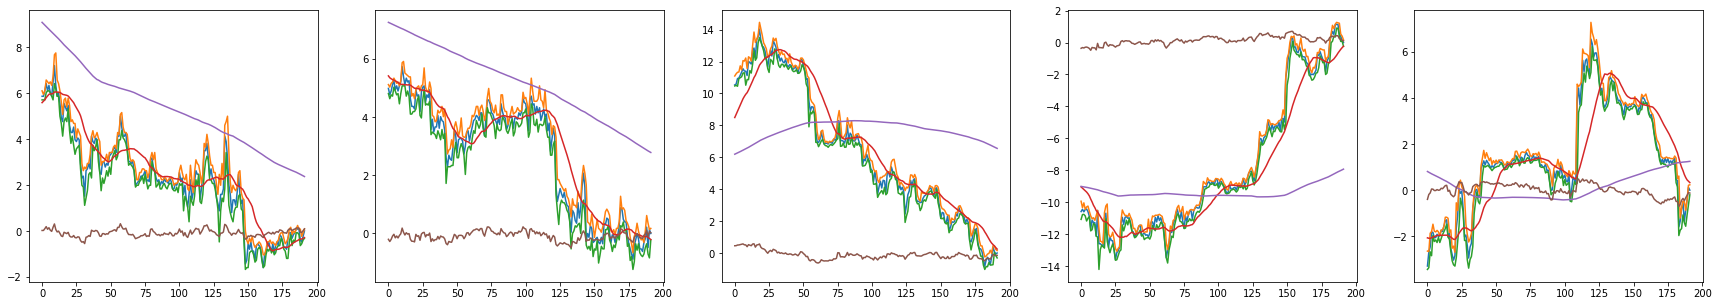

In [43]:
num_parallel = 5
envs = [environment() for _ in range(num_parallel)]

if True:    
    fig, ax = plt.subplots(1,num_parallel,figsize=(30,5))
    for o in range(num_parallel):
        x = envs[o].reset(True)[0]
        x_ = np.transpose(x)
        for i in x_:
            ax[o].plot(i) if num_parallel > 1 else ax.plot(i) 

In [46]:
n = 100000000
agent.train(num_steps = n, envs = envs, warmup = 0, log_interval = 10000, train_steps_per_step=1)

 1351/10000 [===>..........................] - ETA: 39:18 - loss: 0.3318 - mean q: 1.5926 - rewards: 0.0061 - reward sum: 40.6077 - l/s: -0.9523 - t: 262.8419

break!


In [40]:
agent.save_weights()

In [41]:
#m = agent.memory
#agent.memory = m
#del m